# Assignment 03 (  Text classification )

---

Bidirectional RNN with Dataset 02

---


CSE 4238 - Soft Computing Lab

---


ID : 170104037

---


Sec : A

---


Date : 02/09/2021

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Importing necessary libraries

In [2]:
from pathlib import Path
from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import nltk
from keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


---

# Dataset

Now , 037 % 3 = 1 which is Dataset 02

---

# Model

(37+2)%5 = 4  which is Bidirectional RNN

---

In [3]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/soft comp/Assignment 3/Dataset/Dataset2.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1L7gRzRsyWzQ6jtRg86q81aVfKbREYv2A',
        dest_path=DATA_PATH,
    )

# Dataset

*   8000 data with polarity 0
*   2314 data with polarity 2314
*   Randomizing dataset



In [11]:
dataset = pd.read_csv(DATA_PATH, engine = 'python')

dataset = dataset.sample(frac=1, random_state = 37)
print(dataset['polarity'].value_counts())
dataset

0    8000
1    2314
Name: polarity, dtype: int64


,text,polarity
4885,Q: Do you get a prize? A: I don't know. I'm a ...,0
4645,@JonathanRKnight the summer will never end! yo...,0
10102,OF COURSE HE IS SUFFERING FROM DEPRESSION OF L...,1
1238,cooking for Mothers Day,0
4372,Darion could be a sweet dream or a beautiful n...,0
...,...,...
4118,Ugh...Time to get ready for work! Actually I ...,0
988,In 24hrs time I will be at uni waiting to star...,0
9036,im gnna go to sleep i have depression i love m...,1
4459,Love you guys! I'm going to work in a few. Kn...,0


# Dividing dataset into training,validating and testing


*   60%, 20%, 20% split for training, validation and test sets.
*   Separating data and label
*   Total 6188 data for training, 2063 data for validation and 2063 data for testing


In [12]:
#Produces a 60%, 20%, 20% split for training, validation and test sets.
train_data, test_data, validation_data = np.split(dataset.sample(frac=1), [int(.6*len(dataset)), int(.8*len(dataset))])

print(train_data.shape)
print(train_data['polarity'].value_counts())
print(test_data.shape)
print(test_data['polarity'].value_counts())
print(validation_data.shape)
print(validation_data['polarity'].value_counts())

#separating data and label
train_x = np.array(train_data.iloc[:, 0])
train_y = np.array(train_data.iloc[:, 1])

test_x = np.array(test_data.iloc[:, 0])
test_y = np.array(test_data.iloc[:, 1])

validation_x = np.array(validation_data.iloc[:, 0])
validation_y = np.array(validation_data.iloc[:, 1])

(6188, 2)
0    4803
1    1385
Name: polarity, dtype: int64
(2063, 2)
0    1588
1     475
Name: polarity, dtype: int64
(2063, 2)
0    1609
1     454
Name: polarity, dtype: int64


# Preprocessing Dataset


*   Removing mentions (@username), URLs (http links) ,hashtags. 



In [13]:

def processing(X,type='porter'):
    stemmer= nltk.stem.PorterStemmer()
    X_proc = []
    for sentence in X:
       # Remove mentions (@username), all URLs, all hashtags.  (\S+ matches with everything that is not a whitespace)
        sentence = re.sub("@\S+|http\S+|#\S+", "", str(sentence))
        X_proc.append(sentence)
    return X_proc 

train_x = processing(train_x)


# Hyperparameters

In [14]:
hparams = {
    "max_num_words": 60000,
    "max_sequence_length": 70,
    "epoch": 10
}

# Tokenization



*   Tokenizing 
*   Removing puncuation marks



In [15]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=hparams["max_num_words"],filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(train_x)

tokenizer.word_index['<unk>'] = 0
tokenizer.index_word[0] = '<unk>'

def prep_text(texts, tokenizer, max_sequence_length):
    
    # Turns text into into padded sequences.
    text_sequences = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_sequence_length)

train_data = prep_text(train_x, tokenizer, hparams["max_sequence_length"])
test_data = prep_text(test_x, tokenizer, hparams["max_sequence_length"])
validation_data = prep_text(validation_x, tokenizer, hparams["max_sequence_length"])

# print(train_data)
# print(train_data.shape)
# print(test_data)
# print(test_data.shape)
# print(validation_data)
# print(validation_data.shape)

# Model Creation (Bidirectional RNN)


*   Activation function : Sigmoid
*   Loss function : Binary crossentropy
*   Optimizer : Adam



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1473024   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         24704     
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 512)         197120    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 256)         164096    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 16)                4240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,863,201
Trainable params: 1,863,201
Non-trainable params: 0
____________________________________________

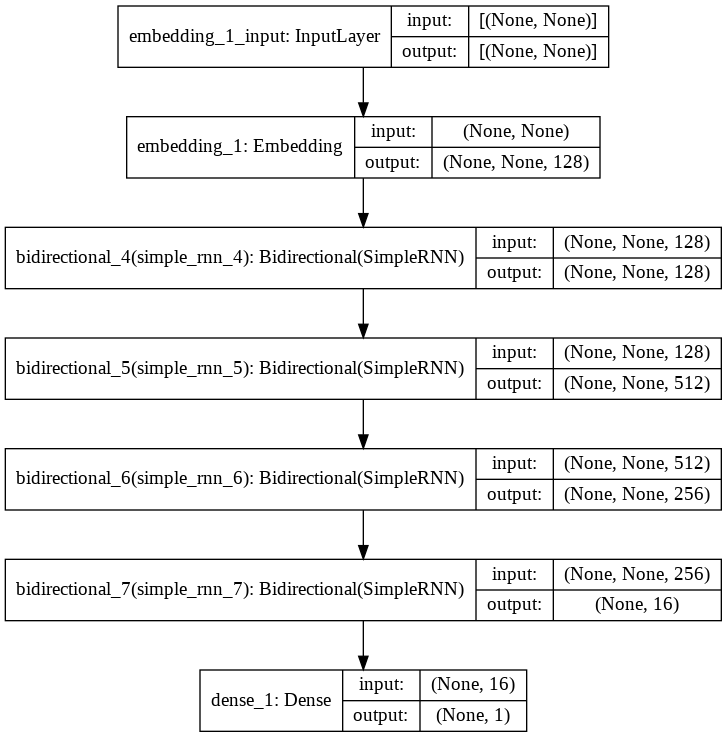

In [16]:
model = tf.keras.Sequential()
model.add(layers.Embedding(len(tokenizer.word_index)+1, 128))
model.add(layers.Bidirectional(layers.SimpleRNN(64, return_sequences = True, dropout = 0.3)))
model.add(layers.Bidirectional(layers.SimpleRNN(256, return_sequences = True, dropout = 0.3)))
model.add(layers.Bidirectional(layers.SimpleRNN(128, return_sequences = True, dropout = 0.3)))
model.add(layers.Bidirectional(layers.SimpleRNN(8, dropout = 0.3)))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()
plot_model(model, to_file = 'Model.png', show_shapes = True, show_layer_names = True)

# Training and validating the model with training and validating data

*  Training Accuracy : 99.11%
*  Training Loss : 0.04
*  Validation Accuracy : 98.84%
*  Validation Loss : 0.05

In [17]:
history = model.fit(train_data, train_y, epochs = hparams["epoch"], validation_data = (validation_data, validation_y), verbose=1)

Epoch 1/10
194/194 [==============================] - 85s 403ms/step - loss: 0.2954 - accuracy: 0.8937 - val_loss: 0.0452 - val_accuracy: 0.9932
Epoch 2/10
194/194 [==============================] - 77s 399ms/step - loss: 0.0404 - accuracy: 0.9931 - val_loss: 0.0432 - val_accuracy: 0.9918
Epoch 3/10
194/194 [==============================] - 77s 398ms/step - loss: 0.0267 - accuracy: 0.9955 - val_loss: 0.0405 - val_accuracy: 0.9908
Epoch 4/10
194/194 [==============================] - 78s 403ms/step - loss: 0.0205 - accuracy: 0.9964 - val_loss: 0.0277 - val_accuracy: 0.9947
Epoch 5/10
194/194 [==============================] - 78s 404ms/step - loss: 0.0112 - accuracy: 0.9985 - val_loss: 0.0357 - val_accuracy: 0.9922
Epoch 6/10
194/194 [==============================] - 77s 399ms/step - loss: 0.0159 - accuracy: 0.9968 - val_loss: 0.0460 - val_accuracy: 0.9869
Epoch 7/10
194/194 [==============================] - 77s 399ms/step - loss: 0.0143 - accuracy: 0.9976 - val_loss: 0.0255 - val_ac

# Plotting the accuracy and loss of training and validation 

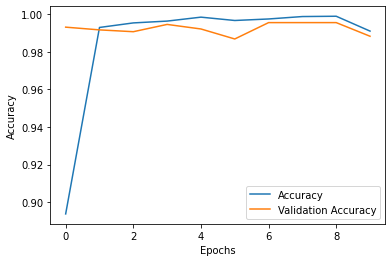

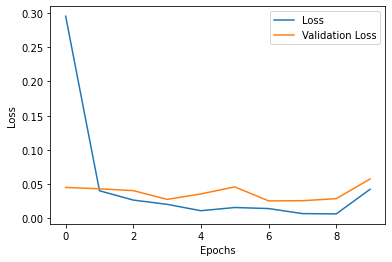

In [18]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_'+ 'accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'],loc='best')
plt.show()
#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_'+ 'loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'],loc='best')
plt.show()

# Performance analysis


*   Calulating accuracy ,precision ,recall and F1-score for all the Train, Validation and Test data
*   Heatmap generation



# Performance analysis for training data


*   Accuracy 99.82
*   Precision 99.71
*   Recall 99.49
*   F1-score 99.60
*   Loss 0.16



194/194 [==============================] - 15s 75ms/step - loss: 0.0165 - accuracy: 0.9982
Train Loss: 0.016491886228322983
Train Accuracy: 0.9982223510742188
Train Precision: 0.9971056439942113
Train Recall: 0.9949458483754513
Train F1-score: 0.9960245753523672


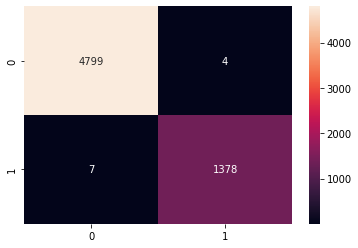

In [19]:
y_pred = model.predict(train_data)

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = model.evaluate(train_data, train_y, verbose = 1)
print('Train Loss:', loss)
print('Train Accuracy:', accuracy)
print('Train Precision:', precision_score(train_y, y_pred))
print('Train Recall:', recall_score(train_y, y_pred))
print('Train F1-score:', f1_score(train_y, y_pred))

sns.heatmap(confusion_matrix(train_y, y_pred), annot = True, fmt = 'g')

# Performance analysis for validation data


*   Accuracy 98.83
*   Precision 97.35
*   Recall 97.35
*   F1-score 97.35
*   Loss 0.05

65/65 [==============================] - 5s 76ms/step - loss: 0.0575 - accuracy: 0.9884
Validation Loss: 0.057504281401634216
Validation Accuracy: 0.9883664846420288
Validation Precision: 0.973568281938326
Validation Recall: 0.973568281938326
Validation F1-score: 0.973568281938326


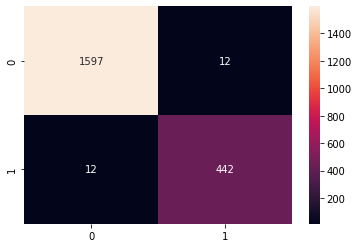

In [20]:
y_pred = model.predict(validation_data)

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = model.evaluate(validation_data, validation_y, verbose = 1)
print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy)
print('Validation Precision:', precision_score(validation_y, y_pred))
print('Validation Recall:', recall_score(validation_y, y_pred))
print('Validation F1-score:', f1_score(validation_y, y_pred))

sns.heatmap(confusion_matrix(validation_y, y_pred), annot = True, fmt = 'g')

# Performance analysis for test data


*   Accuracy 98.59
*   Precision 97.24
*   Recall 96.63
*   F1-score 96.93
*   Loss 0.07

65/65 [==============================] - 5s 76ms/step - loss: 0.0701 - accuracy: 0.9859
Test Loss: 0.07013625651597977
Test Accuracy: 0.9859427809715271
Test Precision: 0.972457627118644
Test Recall: 0.9663157894736842
Test F1-score: 0.969376979936642


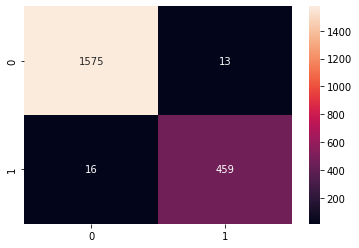

In [21]:
y_pred = model.predict(test_data)

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = model.evaluate(test_data, test_y, verbose = 1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision_score(test_y, y_pred))
print('Test Recall:', recall_score(test_y, y_pred))
print('Test F1-score:', f1_score(test_y, y_pred))

sns.heatmap(confusion_matrix(test_y, y_pred), annot = True, fmt = 'g')